In [1]:
# general packages
import numpy as np
import os
import sys
import inspect

# H-FISTA packages
currentdir = %pwd 
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from lib import Residual
from fista import fista
from helpers import get_data
from lambda_loop import take_lambda_step, initialize_io_dict, get_initial_lambda
from stopping import check_stopping

# plotting tools
import matplotlib.pyplot as plt
from plotting import make_plots, get_diag_plot, get_paper_figure, get_dynamic_field_plot
from scipy.fft import fftshift

%matplotlib inline

# plot style adjustement, remove if jupyter themes not avaiable
from jupyterthemes import jtplot
jtplot.style(context='talk', fscale=1.4, ticks=True, grid=False,)

# further plot configuration
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.aspect"] = "auto"
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams["axes.linewidth"] = 3

### Load and plot data

2023-03-17 16:38:23,079 - H-FISTA.helpers - WARNING - Loading data/observed/J0837+0610.fits as a psrflux ASCII file failed. Trying to load as a FITS file.


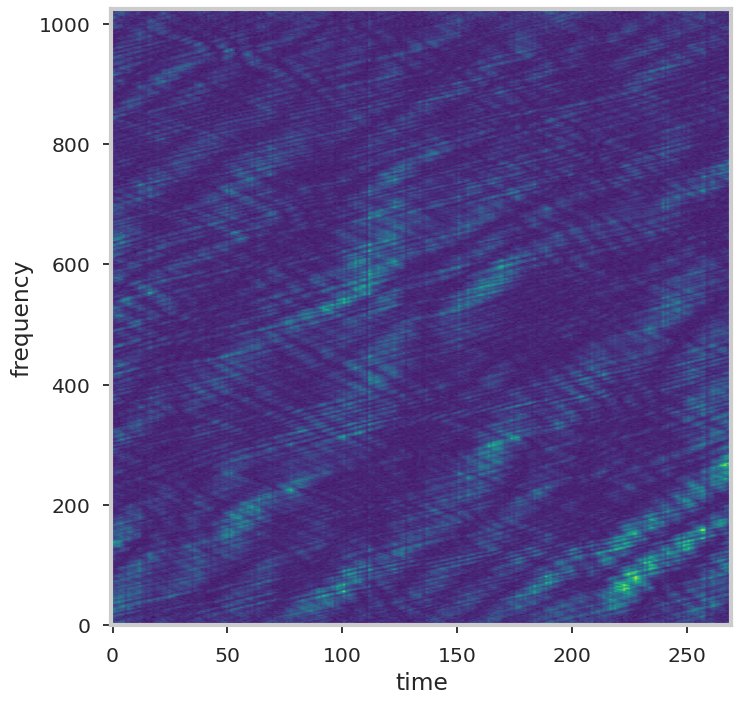

IOStream.flush timed out


In [2]:
data_filename = "data/observed/J0837+0610.fits"
data_raw = get_data(data_filename)
plt.imshow(data_raw.T)
_ = plt.xlabel("time")
_ = plt.ylabel("frequency")

Get rid of striation: divide by the average. Plot normalised data

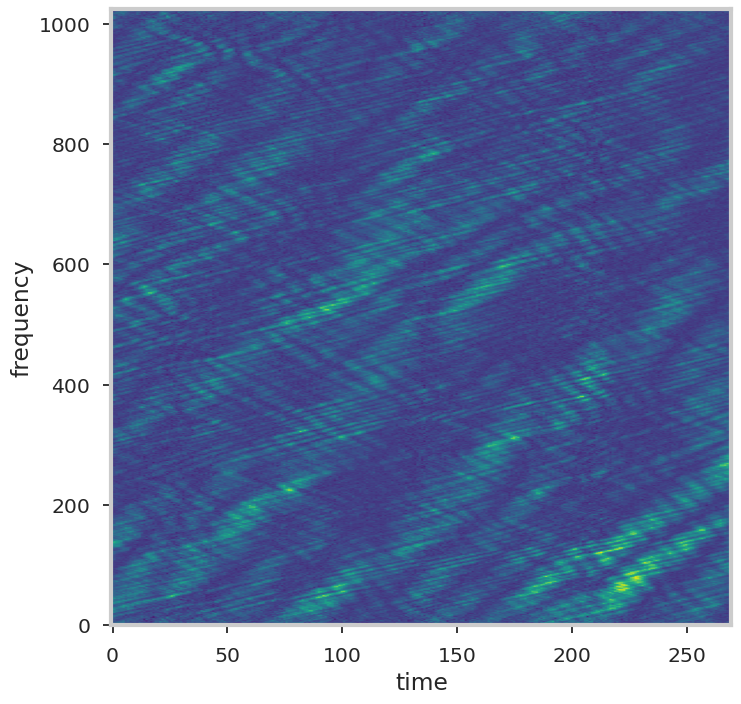

In [3]:
time_axis = 0
timestructure = np.average(np.transpose(data_raw), axis=time_axis)

data = np.divide(data_raw, np.reshape(timestructure, [len(timestructure), 1]))
plt.figure()
plt.imshow(data.T)
_ = plt.xlabel("time")
_ = plt.ylabel("frequency")

## H-FISTA
### Generate initial values

In [4]:
# initial RFI mask does not mask any data
mask = np.ones_like(data)

# initial guess with all power in one wave at the origin
N, M = data.shape
h_init = np.zeros((N, M)) + np.zeros((N, M)) * 1.0j

init_value = np.sqrt(np.mean(data * mask)) * N * M + 0.0j
init_coords = [0, 0]
h_init[init_coords[0], init_coords[1]] = init_value

# H-FISTA configuration
lambda_scale = 1.15
desired_components = 60
fix_phase_value = 0.0
fix_phase_coords = init_coords

# FISTA configuration
FISTA_niter = 80
delay_for_inf = -4
backtrack = True
verbose = False

### Initialise I/O dictionary

In [5]:
# pre-populate the rest of the input output dictionary
io = initialize_io_dict()

# setup the initial guess as a step so that we can use the exact same loop for all runs below
step = 0

io["niters"][step] = 0 

# mask = np.ones_like(data) # in this particular case, we already have a mask
io["masks"][step] = mask
resid = Residual(data, h_init, None, mask)
io["lambdas"][step] = get_initial_lambda(desired_components, delay_for_inf, resid) * lambda_scale
io["models"][step] = h_init
io["demerits"][step] = -1
io["predictions"][step] = resid.prediction
io["residuals"][step] = resid.residual

In [6]:
chosen_step = -1

approved = np.transpose(np.nonzero(h_init))

for step in range(1, 101):
    io["niters"][step] = FISTA_niter
    ref_lambda = io["lambdas"][step-1]/lambda_scale

    lambda_loop_config = {
        "backtrack": backtrack,
        "fix_phase_value": fix_phase_value,
        "fix_phase_coords": init_coords,
        "ref_lambda": ref_lambda, 
        "verbose": verbose,
        "delay_for_inf": delay_for_inf,
        "zero_penalty_coords": approved,
    }

    print()
    print(f"### λ iteration {step} with λ={ref_lambda} and scaling {lambda_scale} ###")
    print() 

    approved = take_lambda_step(data, io, step, **lambda_loop_config)
    io["lambdas"][step] = ref_lambda
    
    if step > 1:
        if check_stopping(io, step):
            chosen_step = step - 1
            print(f"Stopping criterion triggered in step {step}")
            break


### λ iteration 1 with λ=0.07931822160498335 and scaling 1.15 ###

2023-03-17 16:39:51,318 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1 components (approved: 1 and fixed support 0)
2023-03-17 16:39:51,969 - H-FISTA.fista - INFO - backtrack_B3 found 2.33e-05 after 5 iterations. Model has 61 el.
2023-03-17 16:39:52,000 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 61 non-zero elements with demerit 2.55e+05
2023-03-17 16:39:58,941 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 55 non-zero elements with demerit 2.22e+05
2023-03-17 16:40:02,780 - H-FISTA.fista - INFO - Arrived at model with 54 components/ 2.22e+05 after 80 iterations
2023-03-17 16:40:02,821 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 54 components (approved: 0 and fixed support 54)
2023-03-17 16:40:02,822 - H-FISTA.fista - INFO - Fixing support
2023-03-17 16:40:03,510 - H-FISTA.fista - INFO - backtrack_B3 found 2.33e-05 after 5 iterations. Model has 54 el.
2023-03-17 1

2023-03-17 16:41:46,151 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 1463.6412975930316
2023-03-17 16:41:46,153 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.10 per cent of data

### λ iteration 6 with λ=0.03943517446723191 and scaling 1.15 ###

2023-03-17 16:41:46,175 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 99 components (approved: 99 and fixed support 0)
2023-03-17 16:41:46,261 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 135 non-zero elements with demerit 1.6e+05
2023-03-17 16:41:47,146 - H-FISTA.fista - INFO - backtrack_B3 found 2.12e-05 after 4 iterations. Model has 136 el.
2023-03-17 16:41:47,409 - H-FISTA.fista - INFO - backtrack_B3 found 2.56e-05 after 2 iterations. Model has 135 el.
2023-03-17 16:41:51,710 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 135 non-zero elements with demerit 1.59e+05
2023-03-17 16:41:54,693 - H-FISTA.fista - INFO - Arrived at model with 135 components/ 1.59e+

2023-03-17 16:43:08,206 - H-FISTA.fista - INFO - backtrack_B3 found 3.1e-05 after 3 iterations. Model has 446 el.
2023-03-17 16:43:13,023 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 446 non-zero elements with demerit 1.01e+05
2023-03-17 16:43:15,962 - H-FISTA.fista - INFO - Arrived at model with 446 components/ 1.01e+05 after 80 iterations
2023-03-17 16:43:15,970 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 727.6884019850563
2023-03-17 16:43:15,971 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.20 per cent of data

### λ iteration 11 with λ=0.01960625129753684 and scaling 1.15 ###

2023-03-17 16:43:16,001 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 446 components (approved: 446 and fixed support 0)
2023-03-17 16:43:16,160 - H-FISTA.fista - INFO - backtrack_B3 found 1.59e-05 after 1 iterations. Model has 587 el.
2023-03-17 16:43:16,180 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 587 non-zero elemen

2023-03-17 16:44:31,501 - H-FISTA.fista - INFO - backtrack_B3 found 4.98e-05 after 8 iterations. Model has 1145 el.
2023-03-17 16:44:36,225 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 1138 non-zero elements with demerit 6.81e+04
2023-03-17 16:44:39,117 - H-FISTA.fista - INFO - Arrived at model with 1138 components/ 6.81e+04 after 80 iterations
2023-03-17 16:44:39,135 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1138 components (approved: 0 and fixed support 1138)
2023-03-17 16:44:39,136 - H-FISTA.fista - INFO - Fixing support
2023-03-17 16:44:39,294 - H-FISTA.fista - INFO - backtrack_B3 found 1.59e-05 after 1 iterations. Model has 1138 el.
2023-03-17 16:44:39,314 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 1138 non-zero elements with demerit 6.63e+04
2023-03-17 16:44:39,616 - H-FISTA.fista - INFO - backtrack_B3 found 1.75e-05 after 1 iterations. Model has 1138 el.
2023-03-17 16:44:40,839 - H-FISTA.fista - INFO - backtrack_B3 found 6.03e-05 after 13 i

2023-03-17 16:46:11,314 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 1735 non-zero elements with demerit 5.56e+04
2023-03-17 16:46:15,301 - H-FISTA.fista - INFO - Arrived at model with 1735 components/ 5.56e+04 after 80 iterations
2023-03-17 16:46:15,321 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 111.08881286854329
2023-03-17 16:46:15,323 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.20 per cent of data

### λ iteration 19 with λ=0.006409318327638518 and scaling 1.15 ###

2023-03-17 16:46:15,366 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 1735 components (approved: 1735 and fixed support 0)
2023-03-17 16:46:15,553 - H-FISTA.fista - INFO - backtrack_B3 found 1.59e-05 after 1 iterations. Model has 2055 el.
2023-03-17 16:46:15,581 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 2055 non-zero elements with demerit 5.54e+04
2023-03-17 16:46:17,299 - H-FISTA.fista - INFO - backtrack_B3 found 5.48e-05 afte

2023-03-17 16:47:34,801 - H-FISTA.fista - INFO - backtrack_B3 found 7.3e-05 after 16 iterations. Model has 3416 el.
2023-03-17 16:47:39,488 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 3416 non-zero elements with demerit 4.63e+04
2023-03-17 16:47:42,318 - H-FISTA.fista - INFO - Arrived at model with 3416 components/ 4.63e+04 after 80 iterations
2023-03-17 16:47:42,336 - H-FISTA.lambda_loop - INFO - No components hard-thresholded in substep 1 with threshold 57.741263006060684
2023-03-17 16:47:42,339 - H-FISTA.lambda_loop - INFO - RFI mask now includes 0.20 per cent of data

### λ iteration 23 with λ=0.003664548555866235 and scaling 1.15 ###

2023-03-17 16:47:42,374 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 3416 components (approved: 3416 and fixed support 0)
2023-03-17 16:47:42,514 - H-FISTA.fista - INFO - backtrack_B3 found 1.59e-05 after 1 iterations. Model has 4566 el.
2023-03-17 16:47:42,533 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 4566 non-z

In [7]:
print(f"chosen step: {chosen_step} sparse wavefield components: {np.count_nonzero(io['models'][chosen_step])}")

chosen step: 23 sparse wavefield components: 4526


### Inspect dynamic field progression

#### Plot the magnitude and phase of the dynamic field H

We note that that the magnitude of H is the square root of the dynamic spectrum

We plot the dynamic field for the first three λ iterations, and the chosen step. If no step was chosen, we use the last available step

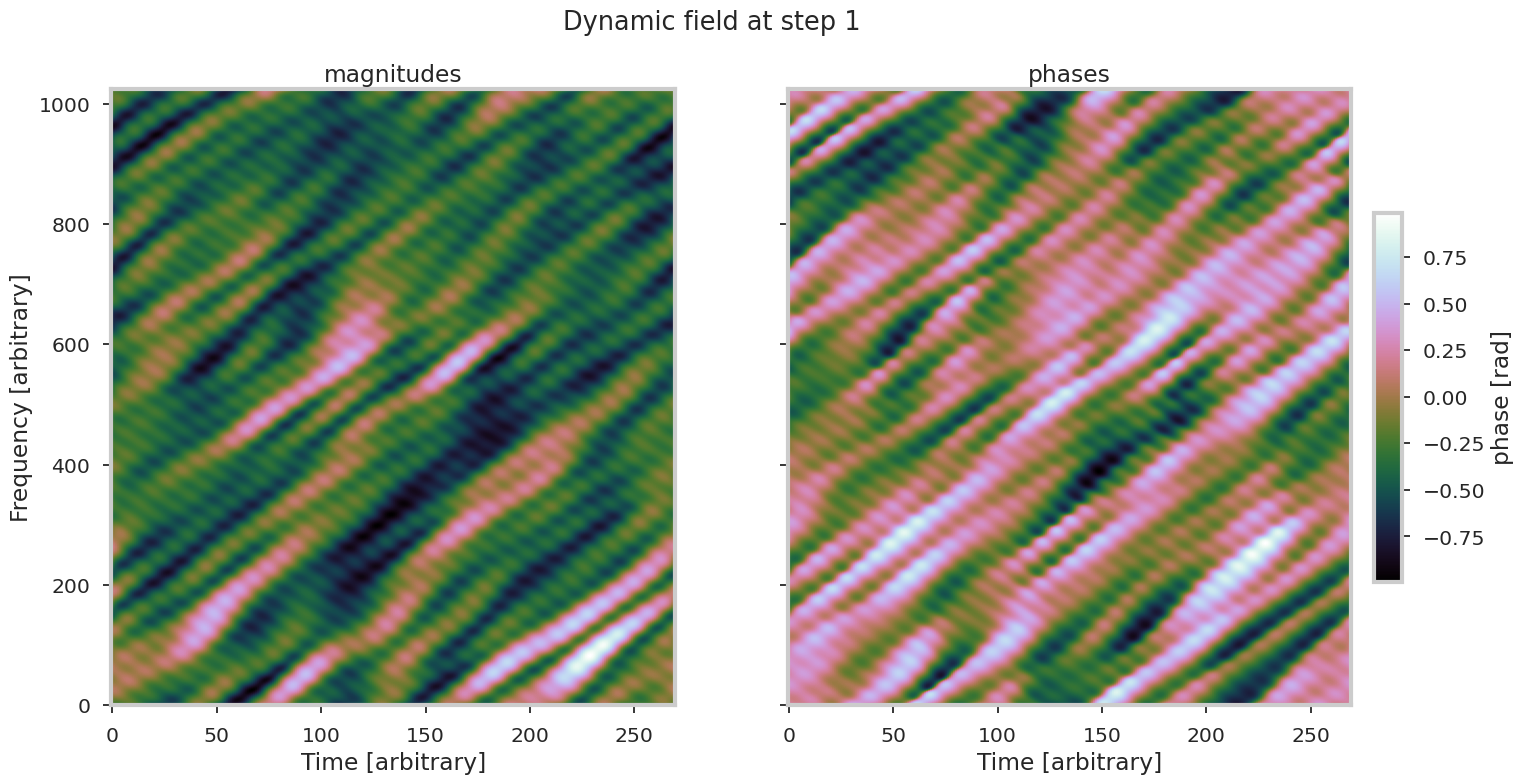

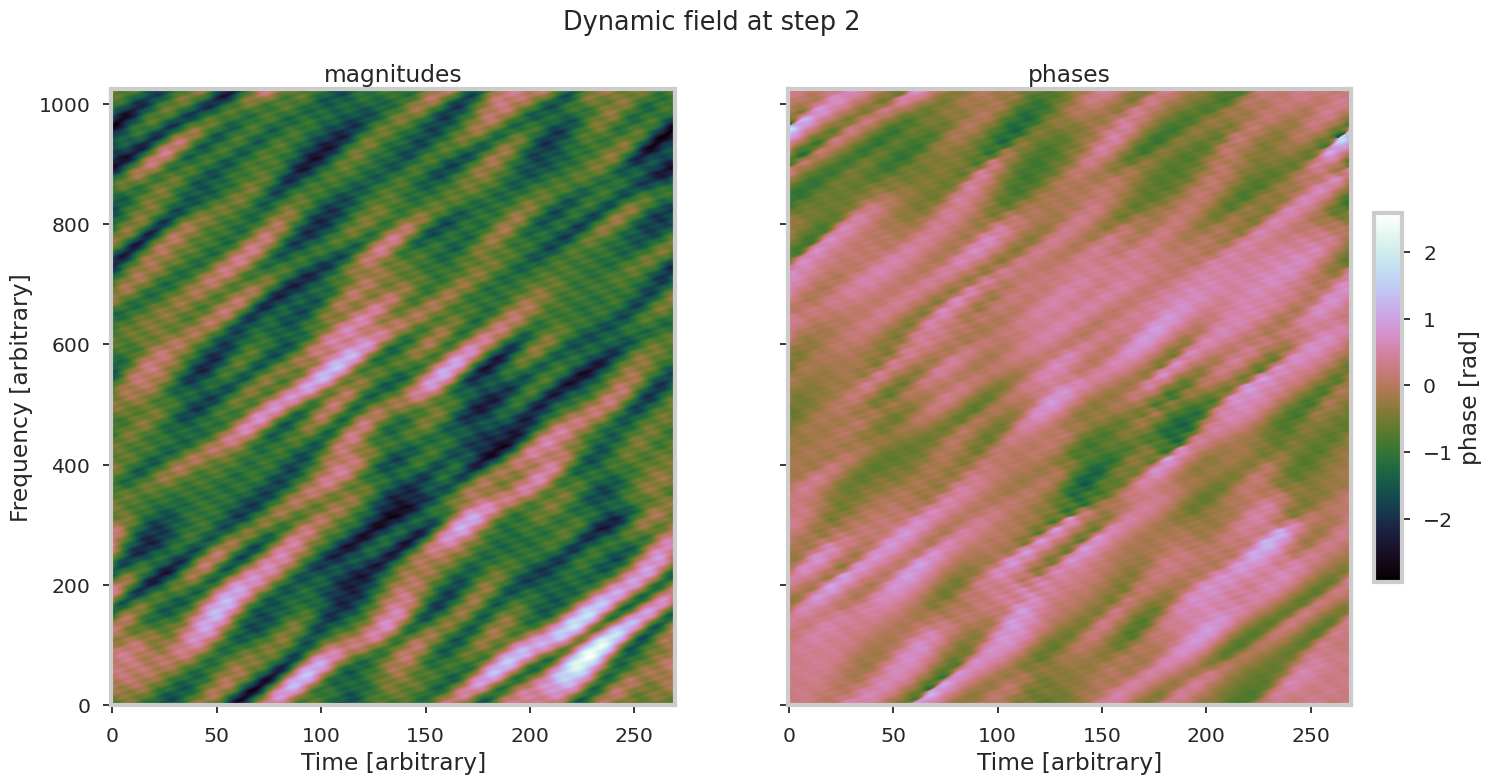

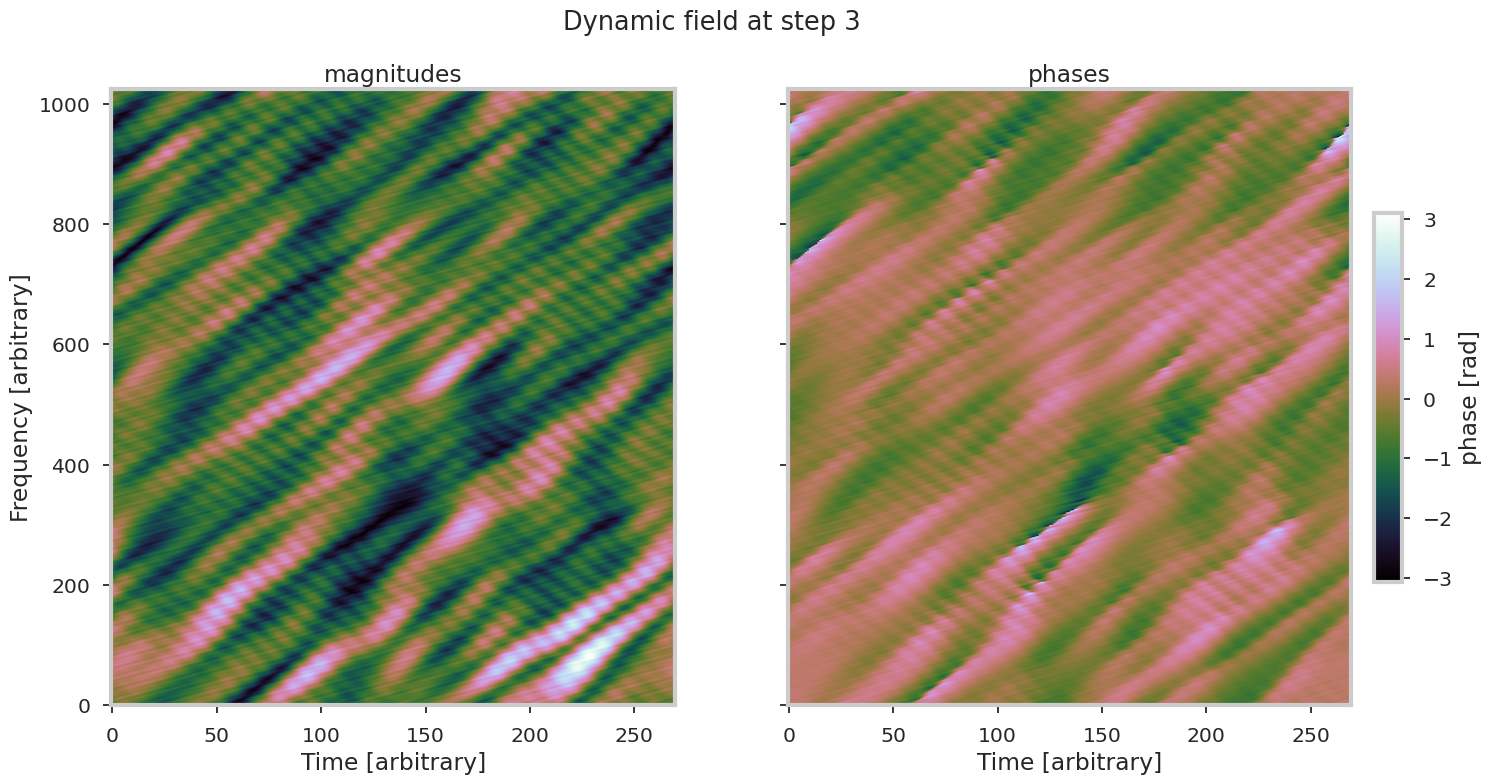

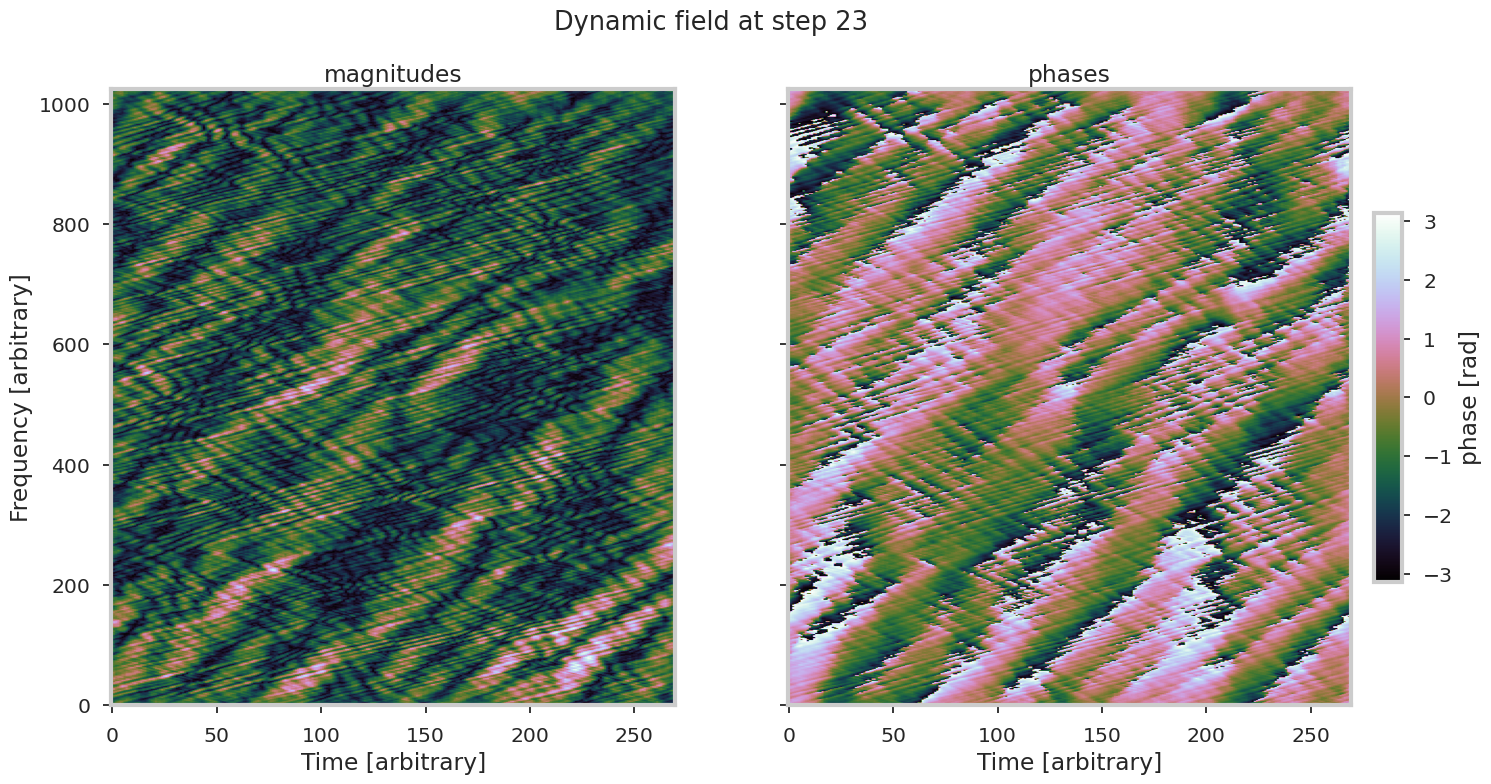

In [8]:
inspect_steps = [1, 2, 3]

if chosen_step > 0:
    inspect_steps.append(chosen_step)
else:
    inspect_steps.append(np.max(list(io["models"].keys())))

for _step in inspect_steps:
    get_dynamic_field_plot(data, io, _step)

### Diagnostic plot

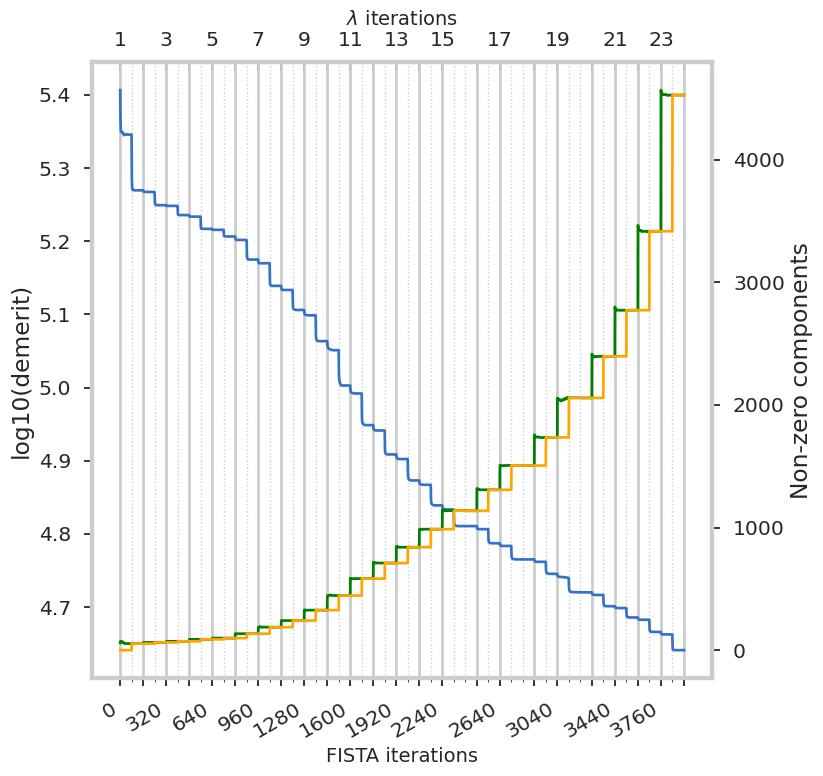

In [9]:
diagnostic_args = {}
if chosen_step > 0:
    diagnostic_args["max_step"] = chosen_step
get_diag_plot(io, **diagnostic_args)

#### Refine with unconstrained FISTA

In [10]:
from densify import get_dense_solution

dense_wavefield = get_dense_solution(io["models"][chosen_step], data, io["masks"][chosen_step])

2023-03-17 16:48:57,663 - H-FISTA.fista - INFO - Running FISTA from an initial guess with 4526 components (approved: 0 and fixed support 0)
2023-03-17 16:48:58,996 - H-FISTA.fista - INFO - backtrack_B3 found 6.03e-05 after 15 iterations. Model has 276480 el.
2023-03-17 16:48:59,017 - H-FISTA.fista - INFO - in iteration 0, x_np1 has 276480 non-zero elements with demerit 2.64e+04
2023-03-17 16:49:00,106 - H-FISTA.fista - INFO - backtrack_B3 found 0.000118 after 7 iterations. Model has 276480 el.
2023-03-17 16:49:05,348 - H-FISTA.fista - INFO - in iteration 50, x_np1 has 276480 non-zero elements with demerit 2.76e+03
2023-03-17 16:49:10,653 - H-FISTA.fista - INFO - in iteration 100, x_np1 has 276480 non-zero elements with demerit 2.76e+03
2023-03-17 16:49:15,822 - H-FISTA.fista - INFO - in iteration 150, x_np1 has 276480 non-zero elements with demerit 2.76e+03
2023-03-17 16:49:21,554 - H-FISTA.fista - INFO - in iteration 200, x_np1 has 276480 non-zero elements with demerit 2.76e+03
2023-0

We have hit a noise floor above. This is due to the striation removal, and depending on the method of removing the striation, the noise floor can be at a different level. Ideally, the intrinsic variability would be included in the modelling.

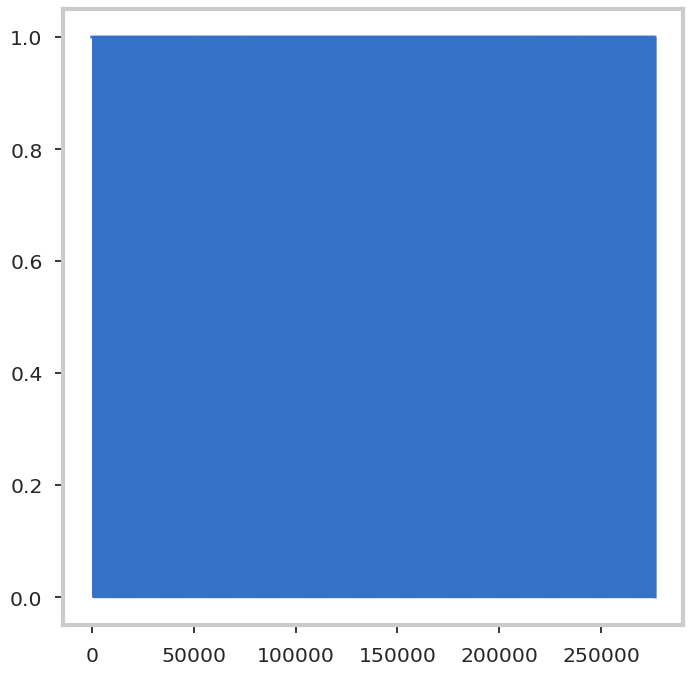

In [11]:
plt.plot(io["masks"][24].ravel())

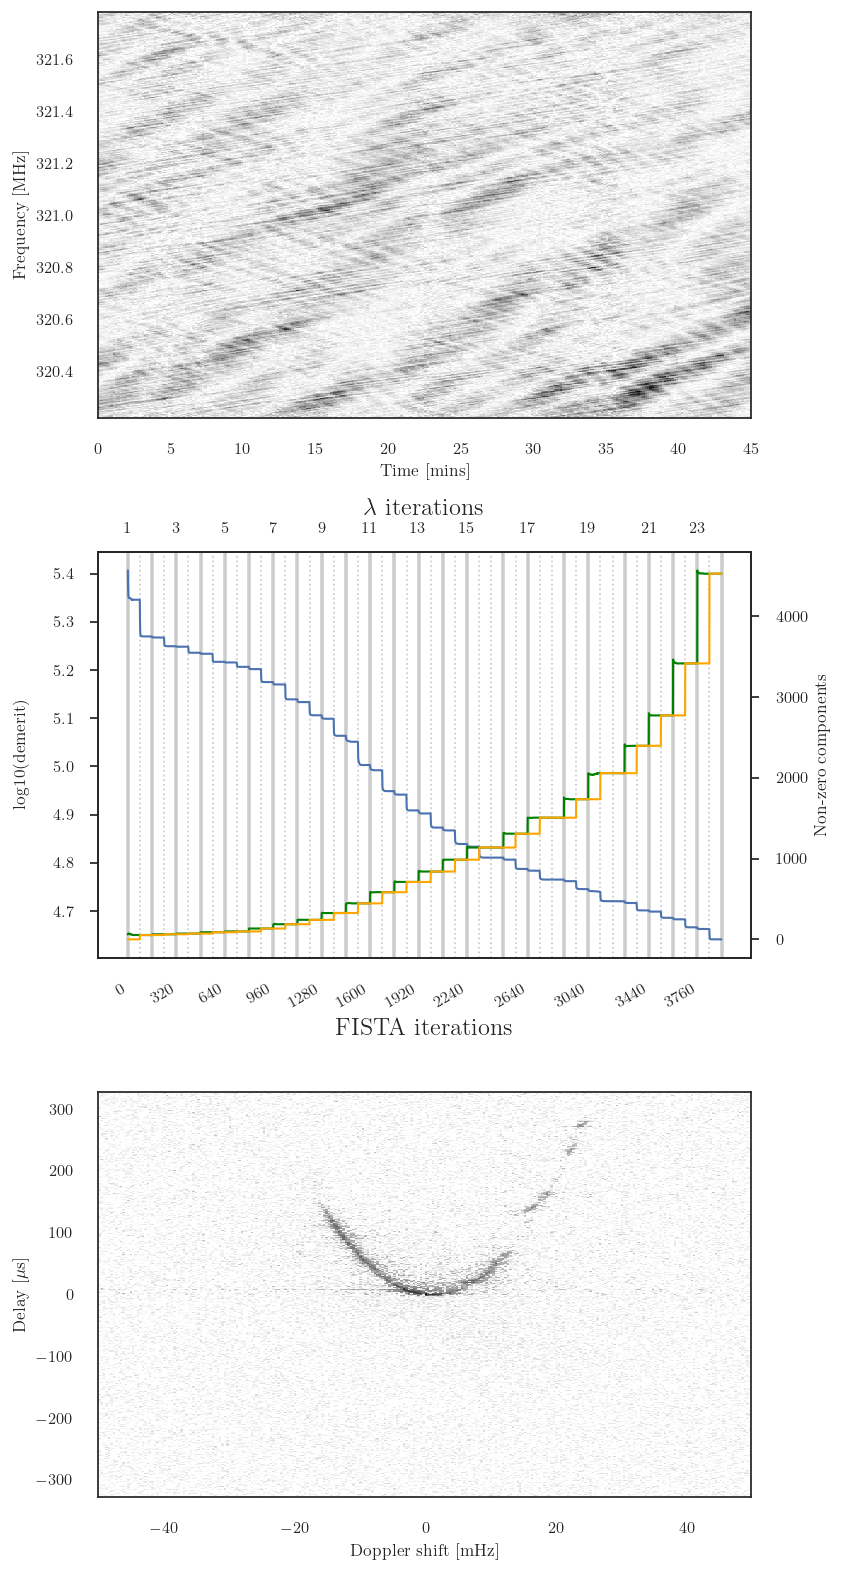

In [15]:
dense_resid = Residual(data, dense_wavefield, None, io["masks"][chosen_step])
fig, axs = get_paper_figure(
    io,
    data,
    chosen_step=chosen_step,
    resid=dense_resid,
    outfn="fig_J0837.eps",
    cfreq=321,
    bw=1.56,
    subint_time=10,
    vmin=0.8757,
    vmin_data=0.45,
)

In [16]:
import pickle

with open("output/J0837+0610_io.pkl", "wb") as fh:
    pickle.dump(io, fh)

with open("output/J0837+0610_dense.pkl", "wb") as fh:
    pickle.dump(dense_resid, fh)

In [17]:
%ls output 

J0837+0610_dense.pkl  J0837+0610_io.pkl
